# Preliminaries

In this notebook, we are going to simulate a 2-Qubit-Coupler and drive it with a new gate scheme. You will:

(1) derive the effective Hamiltonian of the system,

(2) extract its effective description, which allows you to predict the parameters of the gate protocol

(3) numerically simulate the gate and check its fidelity

Comment: [Teach the user how to set up a virtual environment, then also a line with pip install. is the follwoing sufficient?]

Before we start: clone the github project with the needed python packages and data. We propose: run the following cell to clone it and move into the repo folder

In [3]:
# Clone the repo (replace with your repo URL)
!git clone https://github.com/qubitsfan/TransmonCouplerSimulation.git

# Move into the repo folder
%cd TransmonCouplerSimulation

Cloning into 'TransmonCouplerSimulation'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 66 (delta 15), reused 66 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (66/66), 2.74 MiB | 10.03 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/TransmonCouplerSimulation


Let's install the required packages:

In [4]:
pip install numpy scipy matplotlib sympy xarray qutip tqdm

In [5]:
from Floquet_perturbation_theory import *
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import xarray as xr
from scipy.optimize import fsolve
from tqdm.notebook import tqdm
from helper_function import *

from sympy.physics.quantum import Dagger
from sympy.physics.quantum.boson import BosonOp
from sympy.physics.quantum.operatorordering import normal_ordered_form

Here, we start with a transmon-coupler-transmon architecture Hamiltonian (see picture)
$$
\begin{gathered}
    H = \sum_{i=1,2} 4 E_{C_i} n_i^2 - E_{J_i} \cos(\phi_i) + 4 E_{C_c} n_c^2 - E_{J_\Sigma} \sqrt{\cos^2(\phi_\text{ext})+d^2\sin(\phi_\text{ext})^2} \cos(\phi_c) \\
    + g_{1c} n_1 n_c + g_{2c} n_2 n_c + g_{12} n_1 n_2
\end{gathered}
$$
with $d=\frac{E_{Jc_1}-E_{Jc_2}}{E_{Jc_1}+E_{Jc_2}}$ and $E_{J_\Sigma}=E_{Jc_1}+E_{Jc_2}$

Aiming for a parametric two-qubit gate, we implement a small periodic modulation of external flux, i.e., $\phi_{\text{ext}}=\delta \cos(\omega_d t)$. By choosing the frequency
$$
\omega_d \approx \omega_2 - \omega_1
$$,
we aim for a iswap-type process between two qubit states. However, driven quantum systems typically experience "frequency detunings" (aka Stark shifts), which change the frequency at which we should drive. We are going to employ an *effective* framework to predict the correct drive frequency and the Rabi rate of the gate.

Before we simulate anything, let's rewrite the Hamiltonian above using sympy expansions to get a form that is easily manipulateable.

<img src="https://github.com/qubitsfan/TransmonCouplerSimulation/blob/main/Figure/CircuitDiagram.png?raw=1" width="800">

# Warm-Up: Effective Form of the cQED Hamiltonian

Goal: Transform the full-circuit cQED-Hamiltonian to an qubit-like description (two qubits and a frequency-tunable coupler).

We will later see that a clear separation in static and time-modulated parts is the starting point to derive the effective Hamiltonian via perturbation theory.

We start from Taylor expansions of the full coupler-transmon-Hamiltonian:

In [6]:
phi_ext = sp.symbols("\\phi_{ext}")
EJSigma = sp.symbols("E_{J\\Sigma}")
d = sp.symbols("d")

squid = EJSigma * sp.sqrt((sp.cos(phi_ext)) ** 2 + d**2 * (sp.sin(phi_ext)) ** 2)
squid

E_{J\Sigma}*sqrt(d**2*sin(\phi_{ext})**2 + cos(\phi_{ext})**2)

We consider the simplest case where the flux bias point is at symmetry point, i.e., $\phi_{ext}=\delta \cos(\omega_d t)$. When the bias is not 0, there will be multiple frequencies of the drive.

By replacing the external flux of squid Hamiltonian to a perodic modulations

In [7]:
delta = sp.symbols("\\delta")
wd = sp.symbols("\\omega_{d}")
t = sp.symbols("t")

squid_modulated = squid.subs({phi_ext: delta * sp.cos(wd * t)})
squid_modulated

E_{J\Sigma}*sqrt(d**2*sin(\delta*cos(\omega_{d}*t))**2 + cos(\delta*cos(\omega_{d}*t))**2)

Then we can do Taylor expansion and collect the terms in the power of small modulation $\delta$

In [8]:
ejc_expansion = squid_modulated.series(delta, 0, 3).removeO()
ejc_simplified = sp.fu(ejc_expansion)
ejc_collected = sp.collect(ejc_simplified, delta * sp.cos(wd * t))
ejc_collected

E_{J\Sigma}*\delta**2*(d**2*cos(\omega_{d}*t)**2/2 - cos(\omega_{d}*t)**2/2) + E_{J\Sigma}

By ignoring the energy shift of the Hamiltonian, it looks like
$$
\begin{gathered}
    H = \sum_{i=1,2} 4 E_{C_i} n_i^2 - E_{J_i} \cos(\phi_i) + 4 E_{C_c} n_c^2 - E_{J_\Sigma} \cos(\phi_c) \left(1+\frac{d^2-1}{2}\cos(\omega_d t)^2\right) \\
    + g_{1c} n_1 n_c + g_{2c} n_2 n_c + g_{12} n_1 n_2
\end{gathered}
$$
Now we want to implement the second quantization to really write the Hamiltonian in terms of creation and annihilation operators.

In [9]:
# The definitions of non-commuting operators should be different from trivial variables.
# Otherwise, SymPy will treat them as commuting variables and give wrong results when we do algebraic manipulation.

a1 = BosonOp("a_1")
ad1 = Dagger(a1)
a2 = BosonOp("a_2")
ad2 = Dagger(a2)
ac = BosonOp("a_c")
adc = Dagger(ac)

# Define the symbols for the parameters in the Hamiltonian
EC1, EC2, ECc = sp.symbols("E_{C1}, E_{C2}, E_{Cc}")
EJ1, EJ2, EJc = sp.symbols("E_{J1}, E_{J2}, E_{Jc}")
g1c, g2c, g12 = sp.symbols("g_{1c}, g_{2c}, g_{12}")

# Let's first keep the charge and phase operators, and later we can express them in terms of ladder operators if needed.
n1, n2, nc = sp.symbols("n_1, n_2, n_c")
phi1, phi2, phic = sp.symbols("\\phi_1, \\phi_2, \\phi_c")

# Thus the coupled Hamiltonian can be written as:
Hamiltonian = (
    4 * EC1 * n1**2
    - EJ1 * sp.cos(phi1)
    + 4 * EC2 * n2**2
    - EJ2 * sp.cos(phi2)
    + 4 * ECc * nc**2
    - EJc * sp.cos(phic)
    + g1c * n1 * nc
    + g2c * n2 * nc
    + g12 * n1 * n2
)

Now we insert the expression of modulated Josephson energy of the coupler

In [10]:
Hamiltonian_expanded = Hamiltonian.subs({EJc: ejc_collected})
Hamiltonian_expanded

4*E_{C1}*n_1**2 + 4*E_{C2}*n_2**2 + 4*E_{Cc}*n_c**2 - E_{J1}*cos(\phi_1) - E_{J2}*cos(\phi_2) + g_{12}*n_1*n_2 + g_{1c}*n_1*n_c + g_{2c}*n_2*n_c - (E_{J\Sigma}*\delta**2*(d**2*cos(\omega_{d}*t)**2/2 - cos(\omega_{d}*t)**2/2) + E_{J\Sigma})*cos(\phi_c)

We apply the Taylor expansions of the cos-terms to address the anharmonicity of the each transmon

<span style="color:red">[I think this could be an excercise? Expand the Hamiltonian to fourth order in phi1,ph2,phc and simplify the result.]</span>

In [11]:
# we have to go to the fourth order expansion to get the anharmonic terms in each of the cos potential.
Hamiltonian_expanded = sp.series(Hamiltonian_expanded, phi1, 0, 4).removeO()
Hamiltonian_expanded = sp.series(Hamiltonian_expanded, phi2, 0, 4).removeO()
Hamiltonian_expanded = sp.series(Hamiltonian_expanded, phic, 0, 4).removeO()
Hamiltonian_expanded = sp.simplify(Hamiltonian_expanded)
Hamiltonian_expanded

4*E_{C1}*n_1**2 + 4*E_{C2}*n_2**2 + 4*E_{Cc}*n_c**2 + E_{J1}*\phi_1**2/2 - E_{J1} + E_{J2}*\phi_2**2/2 - E_{J2} - E_{J\Sigma}*\delta**2*(d**2 - 1)*cos(\omega_{d}*t)**2/2 + E_{J\Sigma}*\phi_c**2*(\delta**2*(d**2 - 1)*cos(\omega_{d}*t)**2 + 2)/4 - E_{J\Sigma} + g_{12}*n_1*n_2 + g_{1c}*n_1*n_c + g_{2c}*n_2*n_c

Substituting the ladder operator expressions with
$$
\begin{align}
\phi = \left(\frac{2E_C}{E_J}\right)^{\frac{1}{4}}(a+a^\dagger)\\
n = i\left(\frac{2E_J}{32E_C}\right)^{\frac{1}{4}}(a^\dagger-a)
\end{align}
$$
leads to

<span style="color:red">I would consider to merge the next two blocks into one. Maybe even just define one helper function that immediatly spits out : Hamiltonian_expanded_sort. Then the RWA expansion can be done by the students as an exercise.</span>

In [12]:
# Now substitute the ladder operator expressions into the expanded Hamiltonian
Hamiltonian_substituted = Hamiltonian_expanded.subs(
    {
        phi1: (2 * EC1 / EJ1) ** sp.Rational(1, 4) * (a1 + ad1),
        n1: sp.I * (EJ1 / (32 * EC1)) ** sp.Rational(1, 4) * (ad1 - a1),
        phi2: (2 * EC2 / EJ2) ** sp.Rational(1, 4) * (a2 + ad2),
        n2: sp.I * (EJ2 / (32 * EC2)) ** sp.Rational(1, 4) * (ad2 - a2),
        phic: (2 * ECc / EJSigma) ** sp.Rational(1, 4) * (ac + adc),
        nc: sp.I * (EJSigma / (32 * ECc)) ** sp.Rational(1, 4) * (adc - ac),
    }
)

# Expand algebraically (respects noncommutativity)
Hamiltonian_expanded_second = Hamiltonian_substituted.expand()

Hamiltonian_expanded_second

sqrt(2)*E_{C1}*sqrt(E_{J1}/E_{C1})*Dagger(a_1)*a_1/2 - sqrt(2)*E_{C1}*sqrt(E_{J1}/E_{C1})*Dagger(a_1)**2/2 + sqrt(2)*E_{C1}*sqrt(E_{J1}/E_{C1})*a_1*Dagger(a_1)/2 - sqrt(2)*E_{C1}*sqrt(E_{J1}/E_{C1})*a_1**2/2 + sqrt(2)*E_{C2}*sqrt(E_{J2}/E_{C2})*Dagger(a_2)*a_2/2 - sqrt(2)*E_{C2}*sqrt(E_{J2}/E_{C2})*Dagger(a_2)**2/2 + sqrt(2)*E_{C2}*sqrt(E_{J2}/E_{C2})*a_2*Dagger(a_2)/2 - sqrt(2)*E_{C2}*sqrt(E_{J2}/E_{C2})*a_2**2/2 + sqrt(2)*E_{Cc}*sqrt(E_{J\Sigma}/E_{Cc})*Dagger(a_c)*a_c/2 - sqrt(2)*E_{Cc}*sqrt(E_{J\Sigma}/E_{Cc})*Dagger(a_c)**2/2 + sqrt(2)*E_{Cc}*sqrt(E_{J\Sigma}/E_{Cc})*a_c*Dagger(a_c)/2 - sqrt(2)*E_{Cc}*sqrt(E_{J\Sigma}/E_{Cc})*a_c**2/2 + sqrt(2)*E_{J1}*sqrt(E_{C1}/E_{J1})*Dagger(a_1)*a_1/2 + sqrt(2)*E_{J1}*sqrt(E_{C1}/E_{J1})*Dagger(a_1)**2/2 + sqrt(2)*E_{J1}*sqrt(E_{C1}/E_{J1})*a_1*Dagger(a_1)/2 + sqrt(2)*E_{J1}*sqrt(E_{C1}/E_{J1})*a_1**2/2 - E_{J1} + sqrt(2)*E_{J2}*sqrt(E_{C2}/E_{J2})*Dagger(a_2)*a_2/2 + sqrt(2)*E_{J2}*sqrt(E_{C2}/E_{J2})*Dagger(a_2)**2/2 + sqrt(2)*E_{J2}*sqrt(E_

To simplify the expressions, it's better to enforce it in normal order (all creation operators to the left), and simplify with commutation relations of bosonic operators

In [13]:
Hamiltonian_expanded_second = normal_ordered_form(
    Hamiltonian_expanded_second, independent=True
)

# Further simplify the expression by combining like terms and applying power simplification
Hamiltonian_expanded_second = sp.powdenest(Hamiltonian_expanded_second, force=True)

# Collect terms by absorbing the same powers of variables into a simgle term
Hamiltonian_expanded_second = sp.powsimp(Hamiltonian_expanded_second, force=True)

# Get the energy offset by substituting all ladder operators to zero (vacuum expectation value)
constant = Hamiltonian_expanded_second.subs(
    {a1: 0, a2: 0, ac: 0, ad1: 0, ad2: 0, adc: 0}
)

# Subtract the constant from the Hamiltonian to set the ground state energy to zero
Hamiltonian_expanded_second = Hamiltonian_expanded_second - constant

# Collect terms in the order of physcial parameters for better readability
Hamiltonian_expanded_sort = sp.collect(
    Hamiltonian_expanded_second, [delta * sp.cos(wd * t), g12, g1c, g2c]
)

For better readability, we replace the collection of multiplication to the number operator and implement the hardcore approximation(setting energy non-conserving parts to be 0)

<span style="color:red">Hardcore = RWA ? If yes, we should use the name, however after applying hardcore there are still aa terms in the coupling, why? Suggestion: Excersise: Below we print Hamiltonian_expanded_sort.
Define a new object "Hamiltonian_expanded_hardcore" that replaces a^+ a with N (for readability) and performs RWA.
</span>

In [14]:
N1, N2, Nc = sp.symbols("N_1, N_2, N_c")

Hamiltonian_expanded_sort = Hamiltonian_expanded_sort.subs(
    {
        Dagger(a1) * a1: N1,
        Dagger(a2) * a2: N2,
        Dagger(ac) * ac: Nc,
    }
)

Hamiltonian_expanded_hardcore = HardCore(Hamiltonian_expanded_sort, a1, a2, ac)

In [15]:
# Print the static qubit, coupler as well as static coupling of the Hamiltonian by substituting the interaction terms to zero.
print("The first qubit part of the Hamiltonian is: ")
display(
    sp.collect(
        Hamiltonian_expanded_hardcore.subs({N2: 0, Nc: 0, g12: 0, g1c: 0, g2c: 0}), [N1]
    )
)
print("The second qubit part of the Hamiltonian is: ")
display(
    sp.collect(
        Hamiltonian_expanded_hardcore.subs({N1: 0, Nc: 0, g12: 0, g1c: 0, g2c: 0}), [N2]
    )
)
print("The coupler part of the Hamiltonian is: ")
display(
    sp.collect(
        Hamiltonian_expanded_hardcore.subs({N1: 0, N2: 0, g12: 0, g1c: 0, g2c: 0}), [Nc]
    )
)
print("The coupling part of the Hamiltonian is: ")
display(
    sp.simplify(
        sp.collect(
            Hamiltonian_expanded_hardcore.subs({N1: 0, N2: 0, Nc: 0, g1c: 0, g2c: 0}),
            [g12],
        )
    )
    + sp.simplify(
        sp.collect(
            Hamiltonian_expanded_hardcore.subs({N1: 0, N2: 0, Nc: 0, g12: 0, g2c: 0}),
            [g1c],
        )
    )
    + sp.simplify(
        sp.collect(
            Hamiltonian_expanded_hardcore.subs({N1: 0, N2: 0, Nc: 0, g12: 0, g1c: 0}),
            [g2c],
        )
    )
)

The first qubit part of the Hamiltonian is: 


2*sqrt(2)*N_1*sqrt(E_{C1}*E_{J1})

The second qubit part of the Hamiltonian is: 


2*sqrt(2)*N_2*sqrt(E_{C2}*E_{J2})

The coupler part of the Hamiltonian is: 


N_c*(\delta**2*(sqrt(2)*d**2*sqrt(E_{Cc}*E_{J\Sigma})/2 - sqrt(2)*sqrt(E_{Cc}*E_{J\Sigma})/2)*cos(\omega_{d}*t)**2 + 2*sqrt(2)*sqrt(E_{Cc}*E_{J\Sigma}))

The coupling part of the Hamiltonian is: 


sqrt(2)*g_{12}*(E_{J1}*E_{J2})**(1/4)*(-Dagger(a_1)*Dagger(a_2) + Dagger(a_1)*a_2 - a_1*a_2 + Dagger(a_2)*a_1)/(8*(E_{C1}*E_{C2})**(1/4)) + sqrt(2)*g_{1c}*(E_{J1}*E_{J\Sigma})**(1/4)*(-Dagger(a_1)*Dagger(a_c) + Dagger(a_1)*a_c - a_1*a_c + Dagger(a_c)*a_1)/(8*(E_{C1}*E_{Cc})**(1/4)) + sqrt(2)*g_{2c}*(E_{J2}*E_{J\Sigma})**(1/4)*(-Dagger(a_2)*Dagger(a_c) + Dagger(a_2)*a_c - a_2*a_c + Dagger(a_c)*a_2)/(8*(E_{C2}*E_{Cc})**(1/4))

Remark: Though here we only include the symmetric case, one can easily assume a nonzero bias point and omit the changes in the code to compute higher order contributions.

# Initial Numerical Implementation of the System

After knowing the the explicit form of the Hamiltonian, let's implement it for numerical simulations. To eventually perform a gate, we need to know: (a) the drive frequency and (b) the gate time (corresponding to the Rabi rate of the swap).
To predict these values precisely, we will numerically compute an *effective Hamiltonian* via perturbation theory. To make use of the framework that follows the Hamiltonian needs to be split as follows:
$$
\begin{gathered}
    H (t) = E + V(t)\\
\end{gathered}
$$
where $E$ is completely diagonal (describing the system without interactions) and all interactions and time depency needs to be in the perturbative part $V(t)$.

First, we construct the time-independent part $E$:

In [16]:
# we use the typical operators to indicate the non-zero matrix elements between the states of interest.
dim_q1 = 3
dim_q2 = 3
dim_c = 3

w1, w2, wc, alpha1, alpha2, alphac, g1c, g2c, g12 = sp.symbols(
    "\\omega_1, \\omega_2, \\omega_c, \\alpha_1, \\alpha_2, \\alpha_c, g_{1c}, g_{2c}, g_{12}",
    real=True,
)

a_q1 = tensor(destroy(dim_q1), qeye(dim_c), qeye(dim_q2))
a_q2 = tensor(qeye(dim_q1), qeye(dim_c), destroy(dim_q2))
a_qc = tensor(qeye(dim_q1), destroy(dim_c), qeye(dim_q2))

E = np.diag(
    w1 * (a_q1.dag() @ a_q1).full()
    + alpha1 / 2 * (a_q1.dag() @ a_q1.dag() @ a_q1 @ a_q1).full()
    + w2 * (a_q2.dag() @ a_q2).full()
    + alpha2 / 2 * (a_q2.dag() @ a_q2.dag() @ a_q2 @ a_q2).full()
    + wc * (a_qc.dag() @ a_qc).full()
    + alphac / 2 * (a_qc.dag() @ a_qc.dag() @ a_qc @ a_qc).full()
)

<span style="color:red">[Exercise: Now it is your turn: Construct V(t)=V0+V1, by separating it into two quantities V0 (all static couplings) and V1 (everything dependent on delta)]</span>

In [17]:
V0 = (
    g1c * ((a_q1 - a_q1.dag()) @ (a_qc - a_qc.dag())).full()
    + g2c * ((a_q2 - a_q2.dag()) @ (a_qc - a_qc.dag())).full()
    + g12 * ((a_q1 - a_q1.dag()) @ (a_q2 - a_q2.dag())).full()
)

V1 = delta * (a_qc.dag() @ a_qc).full()

Depending on the non-zero matrix elements of E, V0 and V1, we define the correponding analytical form of those matrices.

In [18]:
D = dim_q1 * dim_c * dim_q2

## Analytics 3 levels using sympy
E_analytics = np.zeros(D, dtype=sy.Symbol)
for n1 in range(dim_q1):
    for nc in range(dim_c):
        for n2 in range(dim_q2):
            n = n1 * dim_c * dim_q2 + nc * dim_q2 + n2
            E_analytics[n] = sy.symbols(f"E_{{\\ket{{{n1}{nc}{n2}}}}}", real=True)

## Non-zero matrix elements of static coupling V0 and drive coupling V1
V0_analytics = np.zeros((D, D), dtype=sy.Symbol)
V1_analytics = np.zeros((D, D), dtype=sy.Symbol)
for i1 in range(dim_q1):
    for i2 in range(dim_q2):
        for ic in range(dim_c):
            for jc in range(dim_c):
                for j1 in range(dim_q1):
                    for j2 in range(dim_q2):
                        i = i1 * dim_c * dim_q2 + ic * dim_q2 + i2
                        j = j1 * dim_c * dim_q2 + jc * dim_q2 + j2
                        if V0[i, j] != 0:
                            V0_analytics[i, j] = sy.symbols(
                                f"\\bra{{{i1}{ic}{i2}}}V_0{{\\ket{{{j1}{jc}{j2}}}}}"
                            )
                        if V1[i, j] != 0:
                            V1_analytics[i, j] = sy.symbols(
                                f"\\bra{{{i1}{ic}{i2}}}V_1{{\\ket{{{j1}{jc}{j2}}}}}"
                            )

<span style="color:red">Is above actually needed for calculations? As far as I understand, it is just to illustrate the processes in the next section. if yes: move to helper_function</span>

# Understanding the Resonance Condition

As mentioned in the beginning, we want to create at iswap-type process by driving the system at the frequency $\omega_d \approx \omega_2 - \omega_1$. Intuitively, this should create a swap between the states:
$$ |001\rangle \leftrightarrow |100\rangle$$
Both states are therefore necessary parts of the *effective Hamiltonian*, which we aim for. Said Hamiltonian should therefore be of the form:
$$ H_{eff} = \begin{array}{ccc}
            |001\rangle & |100\rangle & \\
            \delta_0 & \Omega_{01} & |001\rangle\\
            \Omega_{01} & \delta_0  & |100\rangle\\
            \end{array}$$
where we wwant to predict a Rabi rate $\Omega_{01}$ and the resonance condition $\delta_0-\delta_1=0$, induced by Stark shifts on both levels. In this section, we compute...

We can now start numerical simulations and first demonstrate the typical process of rabi coupling and stark shifts from defining an algebaric expression of energy spectrum, static coupling and the first harmonics.
<span style="color:red">Sorry, but what does this sentence mean?</span>

## Rabi rate

We will build a function that allows us to numerically compute the Rabi rate $\Omega_{01}$. First, let us look at the algebraic structure of the processes that constituate the Rabi rate.

In [19]:
state_a = dim_q2 * dim_c  # state |100>
state_b = 1  # state |001>

wd = sp.symbols("\\omega_{d}", real=True)

In [20]:
Heff_Floquet_summed(
    3,
    state_b,
    state_a,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E_analytics,
    V1_analytics,
    V0_analytics,
    analytics=True,
)

\bra{001}V_0{\ket{010}}*\bra{010}V_0{\ket{100}}*conjugate(\bra{010}V_1{\ket{010}})/((E_{\ket{001}} - E_{\ket{010}})*(E_{\ket{001}} - E_{\ket{010}} + \omega_{d})) + \bra{001}V_0{\ket{111}}*\bra{111}V_0{\ket{100}}*conjugate(\bra{111}V_1{\ket{111}})/((E_{\ket{001}} - E_{\ket{111}})*(E_{\ket{001}} - E_{\ket{111}} + \omega_{d}))

From the anlaytical expression, we know that the population transferring is happening in two paths by the 3rd order process.

- 001 -> 010 -> 010 -> 100
- 001 -> 111 -> 111 -> 100

The processes consist of parametric modulation of middle coupler frequency as well as pairwise swapping and creation.

In [21]:
Heff_Floquet(
    3,
    state_b,
    state_a,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E,
    V1,
    V0,
)

1.0*g_{1c}*g_{2c}*conjugate(\delta)/((1.0*\omega_2 - 1.0*\omega_c)*(1.0*\omega_2 - 1.0*\omega_c + \omega_{d})) + 1.0*g_{1c}*g_{2c}*conjugate(\delta)/((-1.0*\omega_1 - 1.0*\omega_c)*(-1.0*\omega_1 - 1.0*\omega_c + \omega_{d}))

Thus, we could have a function that returns the Rabi rates of the swapping rate between two states of interest.

In [22]:
def rabi_rate(fre, amp, order, i, f, E0, V0, V1, analytics=False):
    rabi = Heff_Floquet_summed(
        order,
        i,
        f,
        fre,
        {i: 1, f: 0},  # E_i - wd = E_f
        E0,
        amp / 2 * V1,
        V0=V0,
        analytics=analytics,
    )
    return rabi

<span style="color:red">Where is this function used later on?</span>

## Stark shifts

Similarly, we could understand which processes contribute in the stark shifts of two states. This is particularly important since in the Floquet picture, only two states degenerate hybridized and lead to populations transfer.

In [23]:
Heff_Floquet(
    2,
    state_a,
    state_a,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E_analytics,
    V1_analytics,
    V0_analytics,
    analytics=True,
)

re(\bra{100}V_0{\ket{210}}*\bra{210}V_0{\ket{100}})/(E_{\ket{001}} - E_{\ket{210}} + \omega_{d}) + re(\bra{100}V_0{\ket{201}}*\bra{201}V_0{\ket{100}})/(E_{\ket{001}} - E_{\ket{201}} + \omega_{d}) + re(\bra{100}V_0{\ket{111}}*\bra{111}V_0{\ket{100}})/(E_{\ket{001}} - E_{\ket{111}} + \omega_{d}) + re(\bra{010}V_0{\ket{100}}*\bra{100}V_0{\ket{010}})/(E_{\ket{001}} - E_{\ket{010}} + \omega_{d}) + re(\bra{001}V_0{\ket{100}}*\bra{100}V_0{\ket{001}})/\omega_{d}

In [24]:
Heff_Floquet(
    2,
    state_b,
    state_b,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E_analytics,
    V1_analytics,
    V0_analytics,
    analytics=True,
)

re(\bra{001}V_0{\ket{111}}*\bra{111}V_0{\ket{001}})/(E_{\ket{001}} - E_{\ket{111}}) + re(\bra{001}V_0{\ket{102}}*\bra{102}V_0{\ket{001}})/(E_{\ket{001}} - E_{\ket{102}}) + re(\bra{001}V_0{\ket{012}}*\bra{012}V_0{\ket{001}})/(E_{\ket{001}} - E_{\ket{012}}) + re(\bra{001}V_0{\ket{010}}*\bra{010}V_0{\ket{001}})/(E_{\ket{001}} - E_{\ket{010}}) - re(\bra{001}V_0{\ket{100}}*\bra{100}V_0{\ket{001}})/\omega_{d}

When plugging in the formula we derived before, we have

In [25]:
Heff_Floquet(
    2,
    state_a,
    state_a,
    wd,
    {state_a: 1, state_b: 0},  # E_state_a - wd = E_state_b
    E,
    V1,
    V0,
)

2.0*g_{12}**2/(-1.0*\alpha_1 - 2.0*\omega_1 + \omega_{d}) + 2.0*g_{1c}**2/(-1.0*\alpha_1 - 2.0*\omega_1 + 1.0*\omega_2 - 1.0*\omega_c + \omega_{d}) + 1.0*g_{1c}**2/(1.0*\omega_2 - 1.0*\omega_c + \omega_{d}) + 1.0*g_{2c}**2/(-1.0*\omega_1 - 1.0*\omega_c + \omega_{d}) + 1.0*g_{12}**2/\omega_{d}

In [26]:
def resonant_condition(fre, amp, order, i, f, E0, V0, V1, analytics=False):
    fre = float(np.atleast_1d(fre)[0])
    Heff_ii = Heff_Floquet_summed(
        order,
        i,
        i,
        fre,
        {i: 1, f: 0},  # E_i - wd = E_f
        E0,
        amp / 2 * V1,
        V0=V0,
        analytics=analytics,
    )
    Heff_ff = Heff_Floquet_summed(
        order,
        f,
        f,
        fre,
        {i: 1, f: 0},  # E_i - wd = E_f
        E0,
        amp / 2 * V1,
        V0=V0,
        analytics=analytics,
    )
    diff = Heff_ff - Heff_ii
    return float(np.real(diff))

<span style="color:red">Suggestion: invert order: first resonance condition then Rabi rate. Then we make it an exercise to construct of the function def rabi_rate(fre, amp, order, i, f, E0, V0, V1, analytics=False):</span>

# Numerical Search for Gate paramaters (or: from Resonance Conditions and Rabi rates)

However, in the real setup, the wavefunction of single qubit is no longle localized but in its dressed basis. Thus, computing the swapping rate in the dressed basis is of importance. Thus, when in the real case, we always first numerically diagonalize the system and reexpress operators in the dressed basis.

In that way, we utilize a real setup of transmon coupler system to simulate the iswap gate.

In [27]:
w1 = 3.83 * 2 * np.pi  # GHz
alpha1 = -0.205 * 2 * np.pi  # GHz
w2 = 3.11 * 2 * np.pi  # GHz
alpha2 = -0.216 * 2 * np.pi  # GHz
wc = 4.29 * 2 * np.pi  # GHz
alphac = -0.161 * 2 * np.pi  # GHz

g1c = 0.115 * 2 * np.pi  # GHz
g2c = 0.110 * 2 * np.pi  # GHz
g12 = 0.015 * 2 * np.pi  # GHz

From the parameters, we define the Hamiltonian in terms of qutip, which we will later use for dynamical simulations.

In [28]:
dim_q1 = 3
dim_q2 = 3
dim_c = 3

a_q1 = tensor(destroy(dim_q1), qeye(dim_c), qeye(dim_q2))
a_q2 = tensor(qeye(dim_q1), qeye(dim_c), destroy(dim_q2))
a_qc = tensor(qeye(dim_q1), destroy(dim_c), qeye(dim_q2))

H_q1 = w1 * a_q1.dag() @ a_q1 + (alpha1 / 2) * a_q1.dag() @ a_q1.dag() @ a_q1 @ a_q1
H_q2 = w2 * a_q2.dag() @ a_q2 + (alpha2 / 2) * a_q2.dag() @ a_q2.dag() @ a_q2 @ a_q2
H_c = wc * a_qc.dag() @ a_qc + (alphac / 2) * a_qc.dag() @ a_qc.dag() @ a_qc @ a_qc

V_0 = (
    g1c * ((a_q1 - a_q1.dag()) @ (a_qc - a_qc.dag()))
    + g2c * ((a_q2 - a_q2.dag()) @ (a_qc - a_qc.dag()))
    + g12 * ((a_q1 - a_q1.dag()) @ (a_q2 - a_q2.dag()))
)
V_1 = a_qc.dag() @ a_qc

<span style="color:red">This was already defined before? why do we repeat it here?</span>

From the Hamiltonian, we go to the dressed basis by finding the eigenstates and transformation matrix U.

In [29]:
evals, evecs = (H_q1 + H_q2 + H_c + V_0).eigenstates()
sorted_evals, sorted_evecs = SortedFRFSpectrum(evals, evecs, dim_q1, dim_c, dim_q2)

# transformation matrix from bare basis to dressed basis
U = Qobj(
    np.column_stack(
        [
            sorted_evecs[i, j, k].full()
            for i in range(dim_q1)
            for j in range(dim_c)
            for k in range(dim_q2)
        ]
    ),
    dims=[[dim_q1, dim_c, dim_q2], [dim_q1, dim_c, dim_q2]],
)

H0_dressed = U.dag() @ (H_q1 + H_q2 + H_c + V_0) @ U
V1_dressed = U.dag() @ V_1 @ U
print(
    "Resonant Frequency (GHz): ",
    (sorted_evals[1, 0, 0] - sorted_evals[0, 0, 1]) / (2 * np.pi),
)

Resonant Frequency (GHz):  0.706336526689518


<span style="color:red">Is this called resonant frequency? Maybe rather "dressed drive frequency without drive"? Also: since it is used later on, let's define it as an object here (and call it in plot)</span>

Also, the projectors are used to keep track of populations of different states we interested.

In [30]:
projection_100 = sorted_evecs[1, 0, 0] @ sorted_evecs[1, 0, 0].dag()
projection_010 = sorted_evecs[0, 1, 0] @ sorted_evecs[0, 1, 0].dag()
projection_001 = sorted_evecs[0, 0, 1] @ sorted_evecs[0, 0, 1].dag()
projection_111 = sorted_evecs[1, 1, 1] @ sorted_evecs[1, 1, 1].dag()

## Trying the intuitive approach

Above it was argued that the intuitive idea on driving the coupler at the energy frequency $\omega_d =\omega_1-\omega_2$ does not work (because of amplitude-dependent Stark shifts). But is this really true? Let's do a quick consistency check and sweep the drive frequency vs the drive amplitude:

In [31]:
lwd = np.linspace(0.700, 0.712, 20) * 2 * np.pi
lA = np.linspace(0.001, 0.2, 20) * 2 * np.pi

mesh_wd, mesh_A = np.meshgrid(lwd, lA, indexing="ij")
final_pop_grid = np.zeros((len(lwd), len(lA)))

tlist = np.linspace(0, 200, 1000)

for i, wd in enumerate(tqdm(lwd)):
    for j, A in enumerate(lA):
        result = mesolve(
            [H_q1 + H_q2 + H_c + V_0, [V_1, lambda t, args: A * np.cos(wd * t)]],
            sorted_evecs[1, 0, 0],
            tlist,
            [],
            e_ops=[projection_001],
        )
        final_pop_grid[i, j] = result.expect[0][-1]

  0%|          | 0/20 [00:00<?, ?it/s]

<span style="color:red">What is happening here? Is this me or a general issue?</span>

Text(0.5, 1.0, 'Population in |001> after 200 ns starting from |100>')

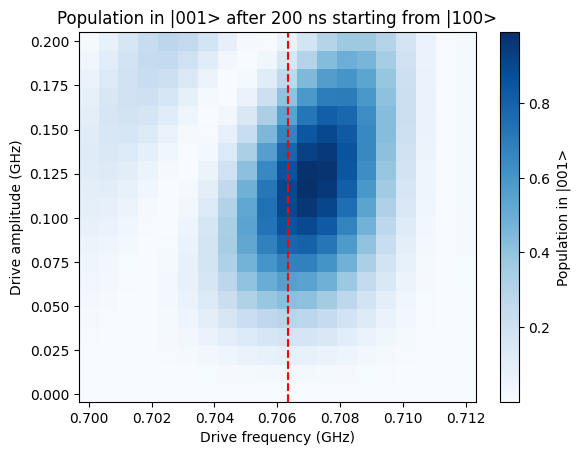

In [32]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(
    mesh_wd / (2 * np.pi),
    mesh_A / (2 * np.pi),
    final_pop_grid,
    shading="auto",
    rasterized=True,
    cmap="Blues",
)
fig.colorbar(pcm, ax=ax, label="Population in |001>")
ax.axvline(
    (sorted_evals[1, 0, 0] - sorted_evals[0, 0, 1]) / (2 * np.pi),
    color="red",
    linestyle="--",
    label="Transition frequency",
)
ax.set_xlabel("Drive frequency (GHz)")
ax.set_ylabel("Drive amplitude (GHz)")
ax.set_title("Population in |001> after 200 ns starting from |100>")

<span style="color:red">I would suggest a quick exercises here: modify the plot to show the transition frequency we computed above.</span>

Oh no: we see indeed that there is a non-trivial resonance condition, that we must implement. Especially for large drive amplitudes (aka fast gates) which we eventually want for stable operations. Let's attack this in the next section.

## Implementing the resonance condition

In [33]:
E_num = sorted_evals.reshape(dim_q1 * dim_c * dim_q2)
V1_num = (
    V1_dressed.full().reshape(dim_q1 * dim_c * dim_q2, dim_q1 * dim_c * dim_q2).real
)

state_a = dim_c * dim_q2  # state |100> corresponds to index 16
state_b = 1  # state |001> corresponds to index 4

<span style="color:red">Excerises: Let's use the function resonant_condition, we constructed above, to find the drive frequency for amplitude $A=0.1*2\pi$ [actually: any reason for why we are doing this line? Just as illustration?]</span>

In [34]:
resonant_condition(2*np.pi*7.08, 0.1*2*np.pi, 2, state_a, state_b, E_num, None, V1_num)

40.04737262296914

<span style="color:red">Excersise: let's sweep the resonance condition for all amplitudes in IA ... [make a few wholes in the next code block]</span>

In [35]:
lresonant_wd_order2 = np.zeros_like(lA, dtype=float)
wd_initial_guess = 2 * np.pi * 0.705

for j, A in enumerate(tqdm(lA)):
    resonant_wd_solution, info, ier, mesg = fsolve(
        resonant_condition,
        wd_initial_guess,
        args=(A, 2, state_a, state_b, E_num, None, V1_num),
        full_output=True,
    )
    if ier != 1:
        print(f"fsolve warning at index {j}: {mesg}")

    lresonant_wd_order2[j] = float(resonant_wd_solution[0])
    wd_initial_guess = lresonant_wd_order2[j]

  0%|          | 0/20 [00:00<?, ?it/s]

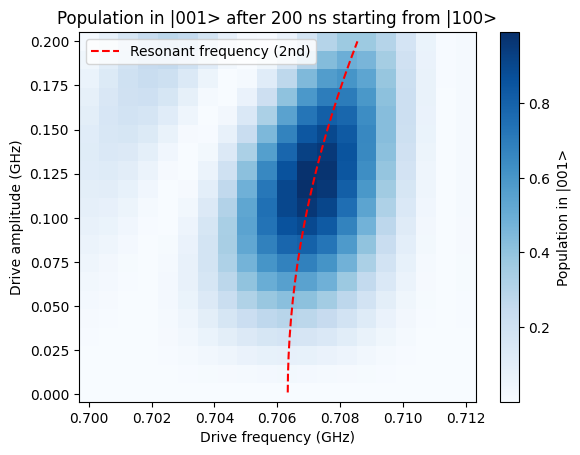

In [36]:
fig, ax = plt.subplots()
pcm = ax.pcolormesh(
    mesh_wd / (2 * np.pi),
    mesh_A / (2 * np.pi),
    final_pop_grid,
    shading="auto",
    rasterized=True,
    cmap="Blues",
)
fig.colorbar(pcm, ax=ax, label="Population in |001>")
ax.plot(
    lresonant_wd_order2 / (2 * np.pi),
    lA / (2 * np.pi),
    ls="--",
    color="red",
    label="Resonant frequency (2nd)",
)
ax.set_xlabel("Drive frequency (GHz)")
ax.set_ylabel("Drive amplitude (GHz)")
ax.set_title("Population in |001> after 200 ns starting from |100>")
ax.legend()

We see that implementing the resonance condition helps us to determine the drive frequency even at high drive amplitudes.

## Population Transfer Rate

Having determined the amplitude-dependent drive frequency in the previous section, we can now use it to estimate the Rabi rate. As we want to stop the drive at the point of maximal population transfer (to obtain an iSWAP gate), we want to have very precise predictions of the Rabi rate. As we compute the Rabi rate pertrubatively to order $r$, it is expected that higher orders can give more precise predictions. Let us test numerically, how high we should in perturbation order.

We take $r=2$ and compute our prediction of the Rabi rate, using our previoulsy defined funtion:

<span style="color:red">Excersise: let's sweep the rabi rate for all amplitudes in IA ... [make a few wholes in the next code block]</span>

In [37]:
lresonant_rabi_order2 = np.zeros_like(lA)

for index in range(len(lA)):
    resonant_frequency = lresonant_wd_order2[index]
    amp = lA[index]
    rabi = rabi_rate(
        resonant_frequency,
        amp,
        2,
        state_b,
        state_a,
        E_num,
        V0=None,
        V1=V1_num,
    )
    lresonant_rabi_order2[index] = np.abs(rabi)

In [40]:
# Evolution along the resonant frequency and drive amplitude
lpop_resonant = np.zeros_like(lA)

tlist = np.linspace(0, 200, 1000)
for i in tqdm(range(len(lA))):
    amp = lA[i]
    fre = lresonant_wd_order2[i]
    result = mesolve(
        [H_q1 + H_q2 + H_c + V_0, [V_1, lambda t, args: amp * np.cos(fre * t)]],
        sorted_evecs[1, 0, 0],
        tlist,
        [],
        e_ops=[projection_001],
    )
    lpop_resonant[i] = result.expect[0][-1]

  0%|          | 0/20 [00:00<?, ?it/s]

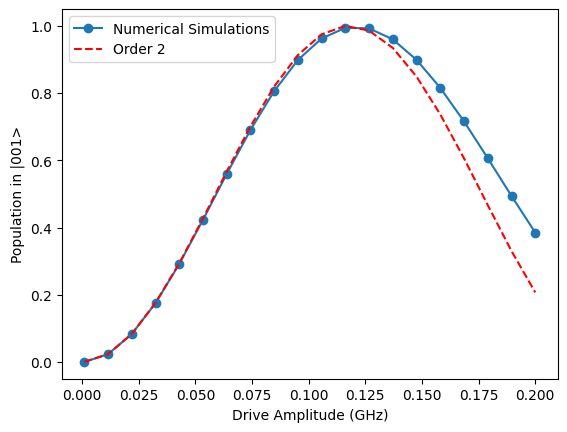

In [41]:
fig, ax = plt.subplots()
ax.plot(lA / (2 * np.pi), lpop_resonant, marker="o", label="Numerical Simulations")
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order2) * tlist[-1]) ** 2,
    color="red",
    linestyle="--",
    label="Order 2",
)
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Population in |001>")
ax.legend()

Can we mitigate the errros in large amplitudes by going to higher order?

In [ ]:
order = 3
lresonant_wd_order3 = np.zeros_like(lA)
lresonant_rabi_order3 = np.zeros_like(lA)

for j, A in enumerate(tqdm(lA)):
    wd_initial_guess = 2 * np.pi * 0.705
    resonant_wd_solution = fsolve(
        resonant_condition,
        wd_initial_guess,
        args=(A, order, state_a, state_b, E_num, None, V1_num),
    )
    lresonant_wd_order3[j] = resonant_wd_solution[0]

    rabi = rabi_rate(
        resonant_wd_solution[0],
        A,
        order,
        state_b,
        state_a,
        E_num,
        V0=None,
        V1=V1_num,
    )
    lresonant_rabi_order3[j] = np.abs(rabi)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
order = 4
lresonant_wd_order4 = np.zeros_like(lA)
lresonant_rabi_order4 = np.zeros_like(lA)

for j, A in enumerate(tqdm(lA)):
    wd_initial_guess = 2 * np.pi * 0.705
    resonant_wd_solution = fsolve(
        resonant_condition,
        wd_initial_guess,
        args=(A, order, state_a, state_b, E_num, None, V1_num),
    )
    lresonant_wd_order4[j] = resonant_wd_solution[0]

    rabi = rabi_rate(
        resonant_wd_solution[0],
        A,
        order,
        state_b,
        state_a,
        E_num,
        V0=None,
        V1=V1_num,
    )
    lresonant_rabi_order4[j] = np.abs(rabi)

  0%|          | 0/20 [00:00<?, ?it/s]

<span style="color:red">Can you please do it more elegantlly by looping over order r=3,4 in one block?</span>

In [42]:
ds = xr.open_dataset("resonant_frequency_and_rabi_rate.nc")
lA = ds["drive_amplitude"].values
lresonant_wd_order2 = ds["resonant_frequency_order_2"].values
lresonant_wd_order3 = ds["resonant_frequency_order_3"].values
lresonant_wd_order4 = ds["resonant_frequency_order_4"].values
lresonant_rabi_order2 = ds["rabi_rate_order_2"].values
lresonant_rabi_order3 = ds["rabi_rate_order_3"].values
lresonant_rabi_order4 = ds["rabi_rate_order_4"].values
ds.close()

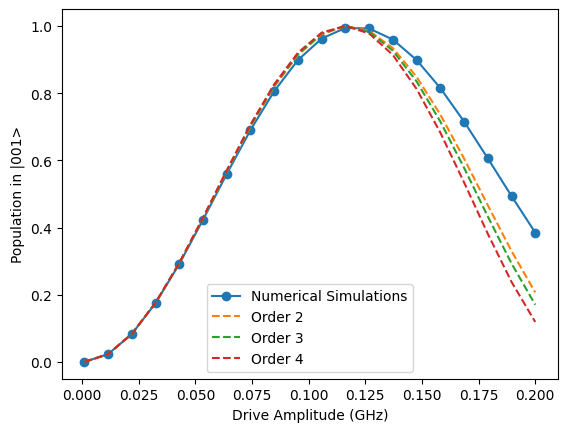

In [43]:
fig, ax = plt.subplots()
ax.plot(lA / (2 * np.pi), lpop_resonant, marker="o", label="Numerical Simulations")
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order2) * tlist[-1]) ** 2,
    linestyle="--",
    label="Order 2",
)
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order3) * tlist[-1]) ** 2,
    linestyle="--",
    label="Order 3",
)
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order4) * tlist[-1]) ** 2,
    linestyle="--",
    label="Order 4",
)
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Population in |001>")
ax.legend()

Hmmm... It seems that increasing order in perturbation theory doesn't improve the result. There must be something missing when considering the process...

<span style="color:red">**Exercise:**</span> Brainstorm a bit and see discuss with others if you can come up with an idea whats happening. The solution will be spoilered in the next section.

# Improving the Fidelities

The solution to the conundrum in the last section is the large leakage to $\ket{010}$ state when going to higher amplitudes. This is ultimately tied to the topic of **Fast Oscillations**.

## Addressing Fast Oscillations

Now we test for the maximal drive amplitude and see the real-time evolutions to figure out what causes the imperfect predictions of the rabi rate.

In [ ]:
test_fre = lresonant_wd_order2[-1]
test_amp = lA[-1]

test_tlist = np.arange(0, 250, 0.01)
test_dynamics = mesolve(
    [H_q1 + H_q2 + H_c + V_0, [V_1, lambda t, args: test_amp * np.cos(test_fre * t)]],
    sorted_evecs[1, 0, 0],
    test_tlist,
    [],
    e_ops=[projection_001, projection_100, projection_010, projection_111],
    options={"progress_bar": "tqdm"},
)

  0%|          | 0/24999 [00:00<?, ?it/s]

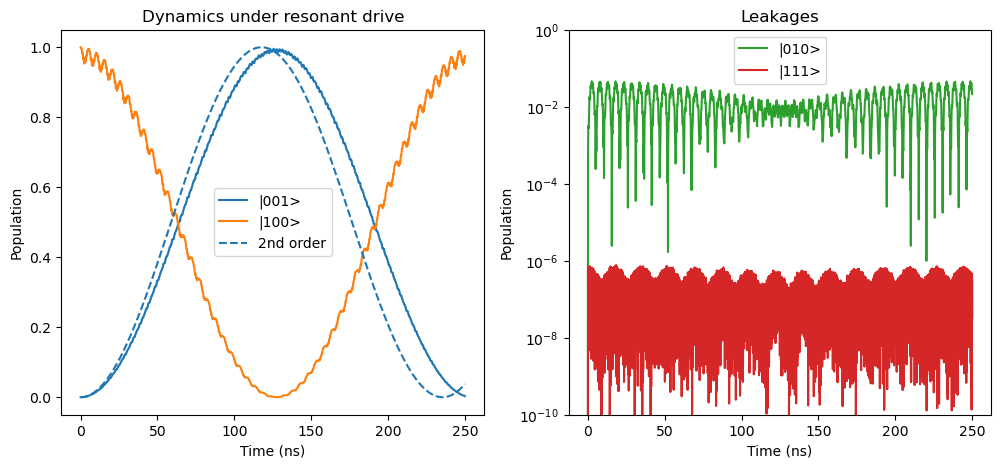

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(test_tlist, test_dynamics.expect[0], label="|001>")
ax[0].plot(test_tlist, test_dynamics.expect[1], label="|100>")
ax[0].plot(
    test_tlist,
    np.sin(np.array(lresonant_rabi_order2[-1]) * test_tlist) ** 2,
    ls="--",
    label="2nd order",
    color="C0",
)
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Population")
ax[0].set_title("Dynamics under resonant drive")
ax[0].legend()

ax[1].plot(test_tlist, test_dynamics.expect[2], label="|010>", color="C2")
ax[1].plot(test_tlist, test_dynamics.expect[3], label="|111>", color="C3")
ax[1].set_ylim(1e-10, 1)
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Population")
ax[1].set_title("Leakages")
ax[1].set_yscale("log")
ax[1].legend()

In [ ]:
initial_state = np.zeros(dim_q1 * dim_c * dim_q2)
initial_state[state_a] = 1

state_c = dim_q2

In [ ]:
rH = 2
rW = 0
psi_t_rHeff2_rW0 = Psi_t_FloquetPerturb(
    rH,
    rW,
    test_fre,
    test_amp,
    {state_a: 1, state_b: 0, state_c: 2},  # E_state_a - wd = E_state_b
    E_num,
    V1_num,
    initial_state,
    test_tlist,
)

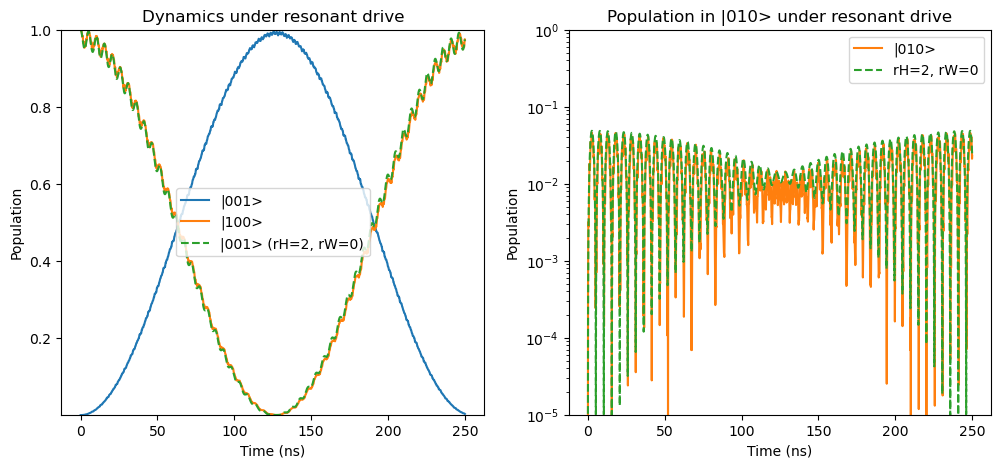

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(test_tlist, test_dynamics.expect[0], label="|001>")
ax[0].plot(test_tlist, test_dynamics.expect[1], label="|100>")
ax[0].plot(
    test_tlist,
    np.abs(psi_t_rHeff2_rW0[state_a, :]) ** 2,
    "--",
    label="|001> (rH=2, rW=0)",
)
ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Population")
ax[0].set_title("Dynamics under resonant drive")
ax[0].legend()
# ax[0].set_yscale("log")
ax[0].set_ylim(1e-3, 1)

# ax[1].plot(test_tlist, test_dynamics.expect[2], label="|010>")
ax[1].plot(test_tlist, test_dynamics.expect[2], label="|010>", color="C1")
ax[1].plot(
    test_tlist,
    np.abs(psi_t_rHeff2_rW0[state_c, :]) ** 2,
    "--",
    label="rH=2, rW=0",
    color="C2",
)
# ax[1].plot(test_tlist, np.abs(test_dynamics.expect[2]-np.abs(psi_t_rHeff2_rW0[state_c, :]) ** 2), label="Difference", color="C3")
ax[1].set_ylim(1e-5, 1)
ax[1].set_xlabel("Time (ns)")
ax[1].set_ylabel("Population")
ax[1].set_title("Population in |010> under resonant drive")
ax[1].set_yscale("log")
ax[1].legend()

In [ ]:
lpop_order2 = np.zeros_like(lA)

for i in tqdm(range(len(lA))):
    amp = lA[i]
    fre = lresonant_wd_order2[i]
    psi_t = Psi_t_FloquetPerturb(
        2,
        0,
        fre,
        amp,
        {state_a: 1, state_b: 0, state_c: 2},  # E_state_a - wd = E_state_b
        E_num,
        V1_num,
        initial_state,
        tlist,
    )
    lpop_order2[i] = np.abs(psi_t[state_b, -1]) ** 2

  0%|          | 0/20 [00:00<?, ?it/s]

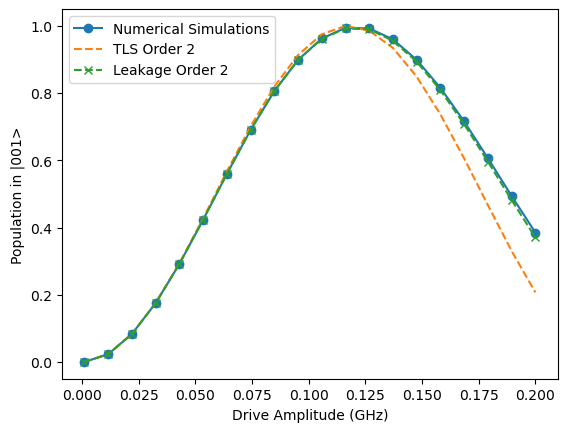

In [ ]:
fig, ax = plt.subplots()
ax.plot(lA / (2 * np.pi), lpop_resonant, marker="o", label="Numerical Simulations")
ax.plot(
    lA / (2 * np.pi),
    np.sin(np.array(lresonant_rabi_order2) * tlist[-1]) ** 2,
    linestyle="--",
    label="TLS Order 2",
)
ax.plot(
    lA / (2 * np.pi),
    lpop_order2,
    marker="x",
    linestyle="--",
    label="Leakage Order 2",
)
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Population in |001>")
ax.legend()

<span style="color:red">Change notation and explain notation carefully before the plot. Suggestion:

2-LS : Effective system of computational states |001> and |100>

3-LS : Effective system of computational states |001> and |100> and leakage state |010>
</span>

<span style="color:red">Move the following two blocks to the next section.</span>

In [ ]:
lleakage1 = np.zeros_like(lA)
lleakage2 = np.zeros_like(lA)

for i in tqdm(range(len(lA))):
    fre = lresonant_wd_order2[i]
    amp = lA[i]

    matrix = Heff_Floquet_matrix_summed(
        2,
        fre,
        {state_a: 1, state_b: 0, state_c: 2},
        E_num,
        amp / 2 * V1_num,
        V0=None,
    )
    lleakage1[i] = np.abs(matrix[0, 2])
    lleakage2[i] = np.abs(matrix[1, 2])

  0%|          | 0/20 [00:00<?, ?it/s]

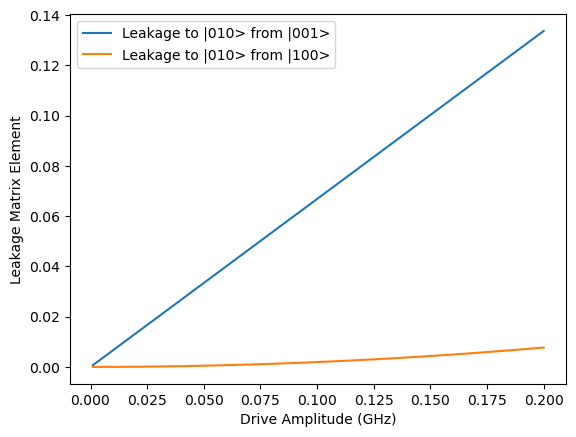

In [ ]:
fig, ax = plt.subplots()
ax.plot(lA / (2 * np.pi), lleakage1, label="Leakage to |010> from |001>")
ax.plot(lA / (2 * np.pi), lleakage2, label="Leakage to |010> from |100>")
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Leakage Matrix Element")
ax.legend()

## Analysing the improved Gate Fidelities

After knowing that the analytical prediction can well predict the time evolutions as well as the leakages. We now compute the time evolutions directly for comparsions.

In [ ]:

def find_optimal_time(fre, amp, order, i, f, l, E0, V1, t_guess):
    """
    Find optimal time that maximizes fidelity with iSWAP gate.

    Parameters:
    -----------
    fre : float
        Drive frequency
    amp : float
        Drive amplitude
    order : int
        Perturbation theory order
    i, f, l : int
        Indices of states forming the computational subspace
    E0 : array
        Energy eigenvalues
    V1 : array
        Perturbation matrix
    fre_guess : float
        Initial guess for drive frequency
    t_guess : float
        Expected gate time (used to set time window)

    Returns:
    --------
    optimal_t : float
        Time at which maximum fidelity occurs
    optimal_fidelity : float
        Maximum achieved fidelity with iSWAP gate
    optimal_U : array (3x3)
        Subsystem unitary at optimal time
    """
    tlist = np.arange(0, 1.5 * t_guess, 0.01)

    # Define initial states for subsystem basis {i, f, l}
    initial_state_a = np.zeros(len(E0))
    initial_state_a[i] = 1
    initial_state_b = np.zeros(len(E0))
    initial_state_b[f] = 1
    initial_state_c = np.zeros(len(E0))
    initial_state_c[l] = 1
    initial_state_list = [initial_state_a, initial_state_b, initial_state_c]

    # Define ideal iSWAP gate for subsystem {i, f, l}
    # iSWAP: |i⟩→i|f⟩, |f⟩→i|i⟩, |l⟩→|l⟩ (spectator)
    U_ideal = np.array([[0, 1j, 0],
                        [1j, 0, 0],
                        [0, 0, 1]], dtype=complex)

    # Storage for time-evolved unitaries
    lU = np.zeros((len(tlist), 3, 3), dtype=complex)

    # Evolve each basis state and construct unitary matrix
    for j, initial_state in enumerate(initial_state_list):
        psi_t = Psi_t_FloquetPerturb(
            order, 0, fre, amp,
            {i: 1, f: 0, l: 2},
            E0, V1, initial_state, tlist,
        )
        # Extract subsystem components at each time
        # psi_t[k, :] is the evolved state at time tlist[k]
        lU[:, 0, j] = psi_t[i, :]  # Project onto state i
        lU[:, 1, j] = psi_t[f, :]  # Project onto state f
        lU[:, 2, j] = psi_t[l, :]  # Project onto state l

    # Compute gate fidelity at each time: F = |Tr(U_ideal† U(t))|² / 3^2
    fidelities = np.zeros(len(tlist))
    for k in range(len(tlist)):
        trace_overlap = np.trace(U_ideal.conj().T @ lU[k])
        fidelities[k] = np.abs(trace_overlap)**2 / 3**2

    max_fidelity = np.max(fidelities)
    t_max = tlist[np.argmax(fidelities)]
    U_max = lU[np.argmax(fidelities)]

    return t_max, max_fidelity, U_max

We take the frequencies predicted by the second order perturbation theory and extract the time that performs iswap interaction. From the given time, we could compute the propagator $U$ and corresponding total fidelity compared to ideal $U_{\text{ideal}}$
$$
\text{Fidelity}=\frac{\text{Tr}\left[U_{\text{ideal}}^\dagger U\right]^2}{d^2}
$$

In [ ]:
lt_optimal_prediction = np.zeros_like(lA)
lfidelity_optimal_prediction = np.zeros_like(lA)
lU_optimal_prediction = np.zeros((len(lA), 3, 3), dtype=complex)

for i in tqdm(range(len(lA))):
    optimal_t, optimal_fidelity, optimal_U = find_optimal_time(
        lresonant_wd_order2[i],
        lA[i],
        2,
        state_a,
        state_b,
        state_c,
        E_num,
        V1_num,
        int(2 * np.pi / lresonant_rabi_order2[i]) / 4,
    )
    lU_optimal_prediction[i] = optimal_U
    lt_optimal_prediction[i] = optimal_t
    lfidelity_optimal_prediction[i] = optimal_fidelity

  0%|          | 0/20 [00:00<?, ?it/s]

Also, the real time evolution is given by

In [ ]:
lfidelity_optimal_numerical = np.zeros_like(lA)
lU_optimal_numerical = np.zeros((len(lA), 3, 3), dtype=complex)

# Define ideal iSWAP gate for comparison
U_ideal = np.array([[0, 1j, 0],
                    [1j, 0, 0],
                    [0, 0, 1]], dtype=complex)

for i in tqdm(range(len(lA))):
    fre = lresonant_wd_order2[i]
    amp = lA[i]

    tlist = np.arange(0, lt_optimal_prediction[i], 0.01)

    # Instead of computing full propagator, evolve each basis state separately
    # This is much faster for extracting just the 3x3 subsystem
    subsystem_indices = [state_a, state_b, state_c]
    U_subsystem = np.zeros((3, 3), dtype=complex)

    for col_idx, initial_state_idx in enumerate(subsystem_indices):
        # Create initial state |state_idx⟩
        initial_state = np.zeros(len(E_num))
        initial_state[initial_state_idx] = 1
        initial_state = Qobj(initial_state, dims=[[dim_q1,dim_c,dim_q2], [1]])

        # Evolve using mesolve
        result = mesolve(
            [H0_dressed, [V1_dressed, lambda t, args: amp * np.cos(fre * t)]],
            initial_state,
            tlist,
            [],
        )
        final_state = result.states[-1]

        # Extract subsystem components to form column of unitary
        for row_idx, j_state in enumerate(subsystem_indices):
            U_subsystem[row_idx, col_idx] = final_state.full()[j_state, 0]

    lU_optimal_numerical[i] = U_subsystem

    # Compute gate fidelity: F = |Tr(U_ideal† U_subsystem)|² / 3²
    trace_overlap = np.trace(U_ideal.conj().T @ U_subsystem)
    lfidelity_optimal_numerical[i] = np.abs(trace_overlap)**2 / 3**2

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
ds = xr.open_dataset("resonant_frequency_and_rabi_rate.nc")
lA = ds["drive_amplitude"].values
lt_optimal_prediction = ds["optimal_time_prediction"].values
lfidelity_optimal_prediction = ds["optimal_fidelity_prediction"].values
lU_optimal_prediction = ds["optimal_U_prediction"].values
lfidelity_optimal_numerical = ds["optimal_fidelity_numerical"].values
lU_optimal_numerical = ds["optimal_U_numerical"].values
ds.close()

In [ ]:
lleakage_error_analytical = np.zeros_like(lA)

for i in tqdm(range(len(lA))):
    U = lU_optimal_prediction[i]
    leakage_analytical = 1 - np.real(np.trace(U[:2,:2].conj().T @ U[:2,:2])) / 2
    lleakage_error_analytical[i] = leakage_analytical

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
lleakage_error_numerical = np.zeros_like(lA)

for i in tqdm(range(len(lA))):
    U = lU_optimal_numerical[i]
    leakage_numerical = 1 - np.real(np.trace(U[:2,:2].conj().T @ U[:2,:2])) / 2
    lleakage_error_numerical[i] = leakage_numerical

  0%|          | 0/20 [00:00<?, ?it/s]

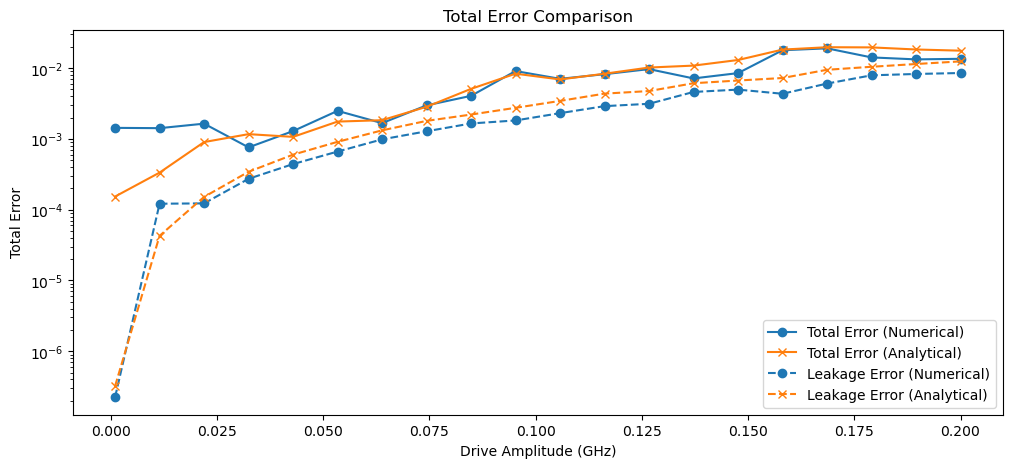

In [ ]:
# compare the optimal predictions with numerical simulations
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(
    lA / (2 * np.pi),
    1-lfidelity_optimal_numerical,
    "o-",
    label="Total Error (Numerical)",
    color="C0"
)
ax.plot(
    lA / (2 * np.pi),
    1-lfidelity_optimal_prediction,
    "x-",
    label="Total Error (Analytical)",
    color="C1"
)
ax.plot(
    lA / (2 * np.pi),
    lleakage_error_numerical,
    "o--",
    label="Leakage Error (Numerical)",
    color="C0"
)
ax.plot(
    lA / (2 * np.pi),
    lleakage_error_analytical,
    "x--",
    label="Leakage Error (Analytical)",
    color="C1"
)
# ax.plot(lA / (2 * np.pi), lleakage_error_numerical + lphase_error_numerical, marker="o", label="Phase Error (Numerical)")
# ax.plot(lA / (2 * np.pi), lleakage_error_analytical+lphase_error_analytical, marker="x", label="Phase Error (Analytical)")
# ax.plot(lA / (2 * np.pi), lleakage_error_numerical + lphase_error_numerical+lrotation_error_numerical, marker="o", label="Rotation Error (Numerical)")
# ax.plot(lA / (2 * np.pi), lleakage_error_analytical + lphase_error_analytical+lrotation_error_analytical, marker="x", label="Rotation Error (Analytical)")
ax.set_xlabel("Drive Amplitude (GHz)")
ax.set_ylabel("Total Error")
ax.set_title("Total Error Comparison")
ax.set_yscale("log")
ax.legend()

Thus, we find that the computation we performs before can well keep track of the leakage error but not in total errors.

Tasks:
- how to improve?
- leakages in other states, i.e., $\ket{000}$ and $\ket{101}$

In [ ]:
ds = xr.Dataset(
    {
        "resonant_frequency_order_2": (("drive_amplitude"), lresonant_wd_order3),
        "resonant_frequency_order_3": (("drive_amplitude"), lresonant_wd_order3),
        "resonant_frequency_order_4": (("drive_amplitude"), lresonant_wd_order4),
        "rabi_rate_order_2": (("drive_amplitude"), lresonant_rabi_order2),
        "rabi_rate_order_3": (("drive_amplitude"), lresonant_rabi_order3),
        "rabi_rate_order_4": (("drive_amplitude"), lresonant_rabi_order4),
        "optimal_time_prediction": (("drive_amplitude"), lt_optimal_prediction),
        "optimal_fidelity_prediction": (("drive_amplitude"), lfidelity_optimal_prediction),
        "optimal_U_prediction": (
            ("drive_amplitude", "subspace_row", "subspace_col"),
            lU_optimal_prediction,
        ),
        "optimal_fidelity_numerical": (("drive_amplitude"), lfidelity_optimal_numerical),
        "optimal_U_numerical": (
            ("drive_amplitude", "subspace_row", "subspace_col"),
            lU_optimal_numerical,
        ),
    },
    coords={
        "drive_amplitude": lA,
        "subspace_row": np.arange(3),
        "subspace_col": np.arange(3),
    },
)
ds.to_netcdf("resonant_frequency_and_rabi_rate.nc", auto_complex=True)